## Robustness Analysis of Lithium Networks

This notebook investigates the robustness of lithium-related networks through simulations and centrality comparisons. The objective is to analyze how these networks respond to various attacks and explore structural metrics like centralities.

---

### Table of Contents

1. [Introduction](#introduction)
2. [Data Loading and Preparation](#data-loading-and-preparation)
3. [Attack Simulation](#attack-simulation)
4. [Compare Centralities of 2020](#compare-centralities-of-2020)


In [19]:
# General Utilities
import os
import random
import warnings
from pathlib import Path

# Data Handling and Processing
import numpy as np
import pandas as pd

# Network Analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt

# Custom Modules
from dataloader import DataLoader

# Set global visualization and warning options
warnings.filterwarnings("ignore")

### Data Loading and Preparation

In [20]:
# Load and preprocess dataset
hs_code = 282520
hs_label = "Lithium"

In [21]:
# Create dir for exporting plots
export_path = os.path.join("single_lithium/graphics", hs_label, hs_label)
Path(export_path).mkdir(parents=True, exist_ok=True)

In [22]:
# Load and preprocess dataset
loader = DataLoader(hs_code=hs_code)

_initialize_data took 52.6162 seconds


In [23]:
# Returns efficiently handled polar dataframe
df = loader.get_data()

In [24]:
# Extracts the distinct years
years = sorted(df['t'].unique())

In [25]:
# Get aggregated export and import over all products
baseline_df = loader.get_baseline(load_precompute=True)

In [26]:
# Get Networkx representation of baseline_df
yearly_graphs = loader.get_yearly_graphs(years)

In [27]:
yearly_baseline_graph = loader.get_yearly_baseline_graphs(baseline_df, years)

In [28]:
df

t    i    j       k         v       q            export_country  \
0      2002   36  124  282520     7.627   2.211                 Australia   
1      2002   36  360  282520    15.395   1.120                 Australia   
2      2002   36  372  282520     1.874   0.008                 Australia   
3      2002   36  380  282520     2.748   0.003                 Australia   
4      2002   36  554  282520     5.832   1.422                 Australia   
...     ...  ...  ...     ...       ...     ...                       ...   
10856  2022  842  757  282520    94.439   1.124  United States of America   
10857  2022  842  764  282520  6188.819  89.237  United States of America   
10858  2022  842  784  282520  2476.180  87.011  United States of America   
10859  2022  842  792  282520     0.873   0.045  United States of America   
10860  2022  842  826  282520  3502.654  72.402  United States of America   

             import_country                  description iso3_o  ...  \
0                    Canada  Lithium oxide and hydroxide    AUS  ...   
1                 Indonesia  Lithium oxide and hydroxide    AUS  ...   
2                   Ireland  Lithium oxide and hydroxide    AUS  ...   
3                     Italy  Lithium oxide and hydroxide    AUS  ...   
4               New Zealand  Lithium oxide and hydroxide    AUS  ...   
...                     ...                          ...    ...  ...   
10856           Switzerland  Lithium oxide and hydroxide   None  ...   
10857              Thailand  Lithium oxide and hydroxide   None  ...   
10858  United Arab Emirates  Lithium oxide and hydroxide   None  ...   
10859                Turkey  Lithium oxide and hydroxide   None  ...   
10860        United Kingdom  Lithium oxide and hydroxide   None  ...   

      tradeflow_imf_d  comlang_ethno  comcol col45 comleg_pretrans  \
0           1151881.5            1.0     0.0   0.0             1.0   
1         1814127.625            0.0     0.0   0.0             0.0   
2          109872.336            1.0     0.0   0.0             1.0   
3         1230163.625            0.0     0.0   0.0             0.0   
4           3335579.5            1.0     0.0   0.0             1.0   
...               ...            ...     ...   ...             ...   
10856            None            NaN     NaN   NaN             NaN   
10857            None            NaN     NaN   NaN             NaN   
10858            None            NaN     NaN   NaN             NaN   
10859            None            NaN     NaN   NaN             NaN   
10860            None            NaN     NaN   NaN             NaN   

       comleg_posttrans  col_dep_ever  empire  sibling_ever  scaled_sci_2021  
0                   1.0           0.0                   1.0          19159.0  
1                   0.0           0.0                   0.0              NaN  
2                   1.0           0.0                   1.0          61908.0  
3                   0.0           0.0                   0.0           7123.0  
4                   1.0           0.0                   1.0         247952.0  
...                 ...           ...     ...           ...              ...  
10856               NaN           NaN    None           NaN              NaN  
10857               NaN           NaN    None           NaN              NaN  
10858               NaN           NaN    None           NaN              NaN  
10859               NaN           NaN    None           NaN              NaN  
10860               NaN           NaN    None           NaN              NaN  

[10861 rows x 40 columns]

In [29]:
baseline_df

t import_country           export_country           v
0       2001    Afghanistan                Australia     319.378
1       2001    Afghanistan                  Austria     142.477
2       2001    Afghanistan               Azerbaijan     190.776
3       2001    Afghanistan                  Bahrain       4.266
4       2001    Afghanistan               Bangladesh    6008.931
...      ...            ...                      ...         ...
672029  2022       Zimbabwe           United Kingdom   85564.157
672030  2022       Zimbabwe  United Rep. of Tanzania   15260.089
672031  2022       Zimbabwe                  Uruguay     220.626
672032  2022       Zimbabwe                 Viet Nam     251.952
672033  2022       Zimbabwe                   Zambia  264848.823

[672034 rows x 4 columns]

### Attack Simulation

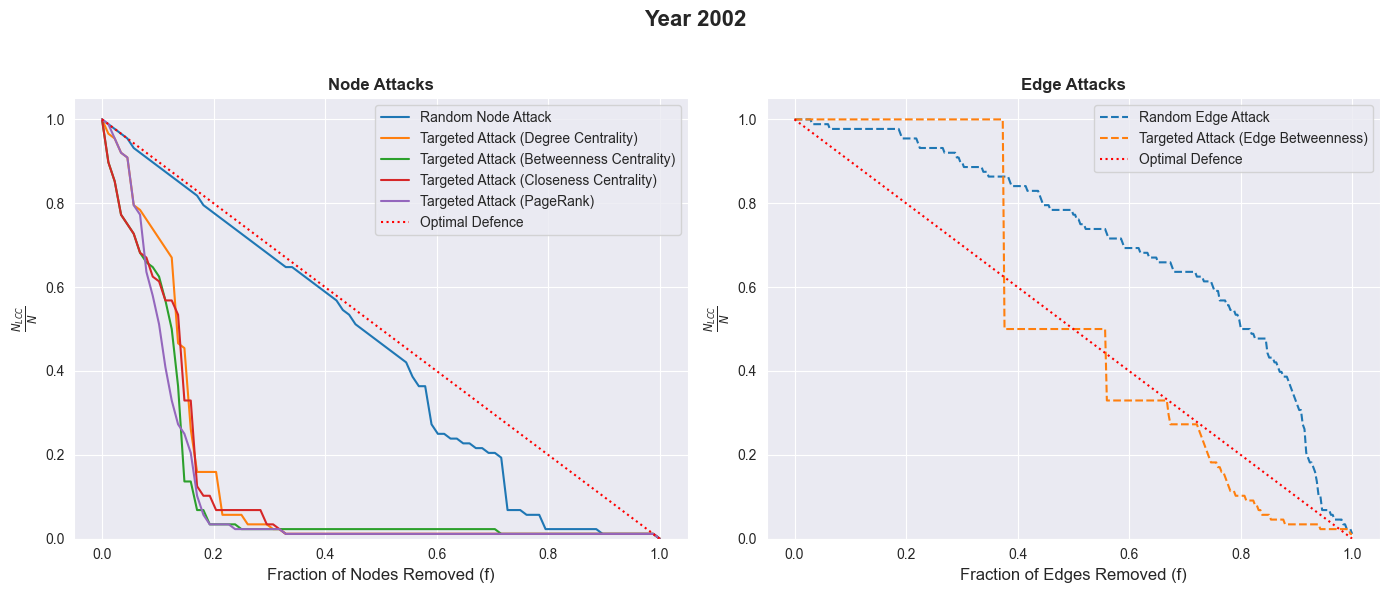

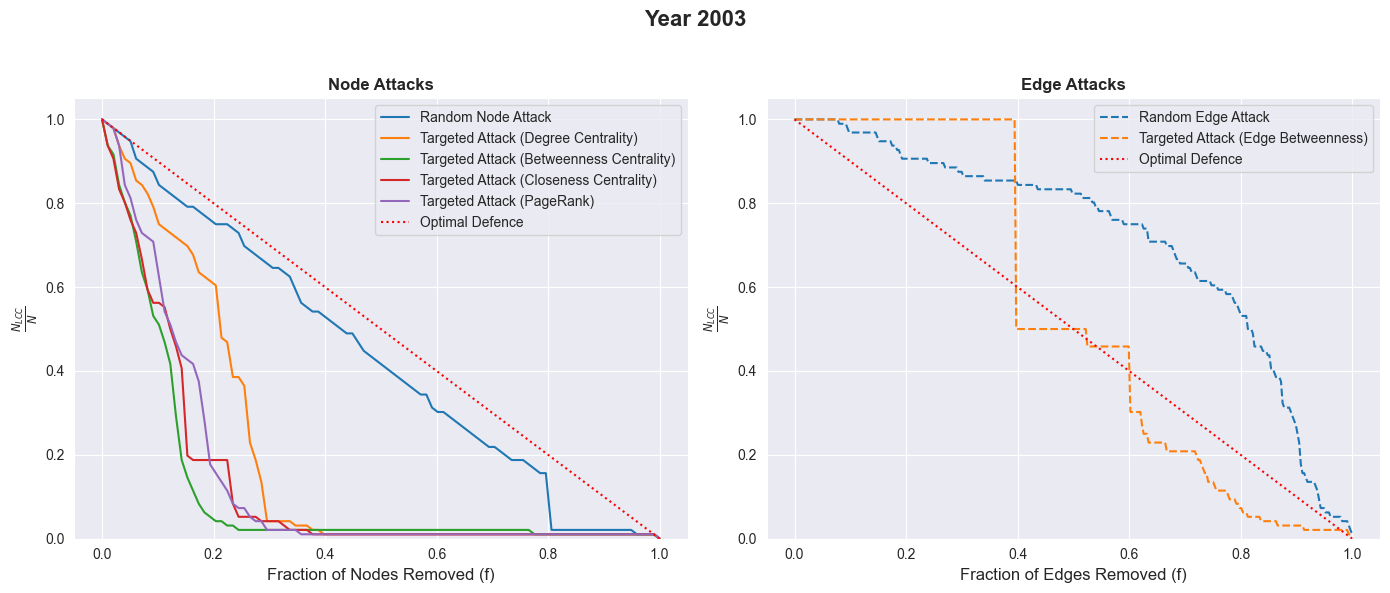

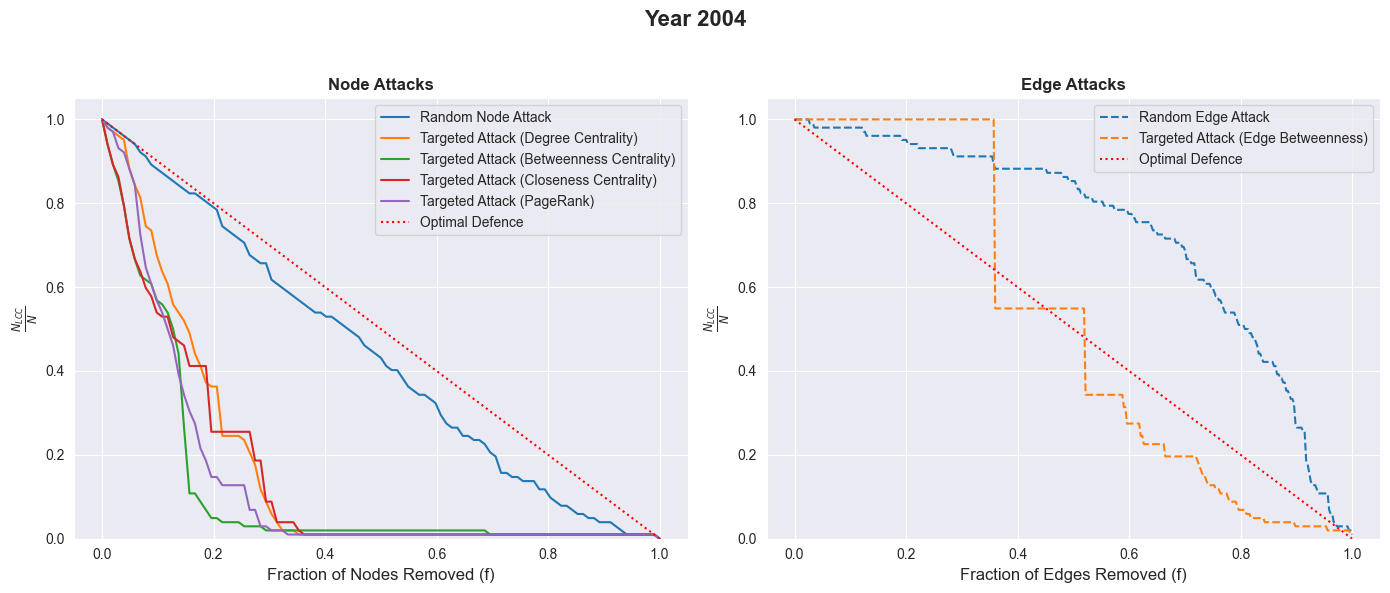

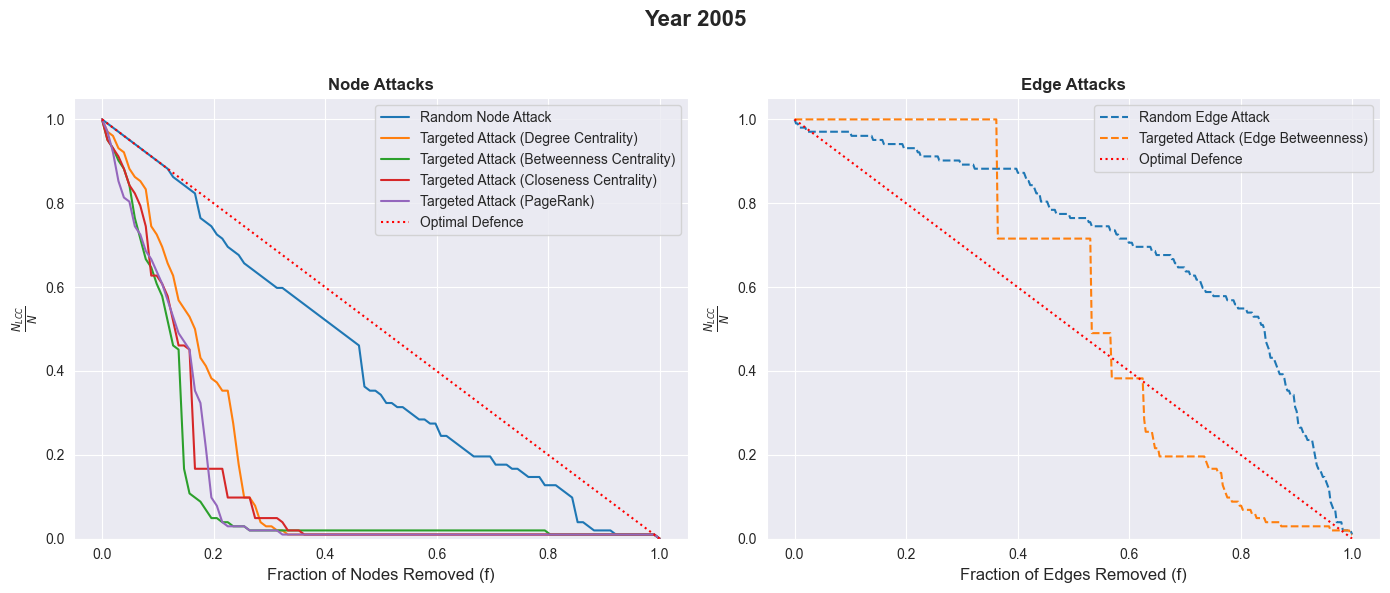

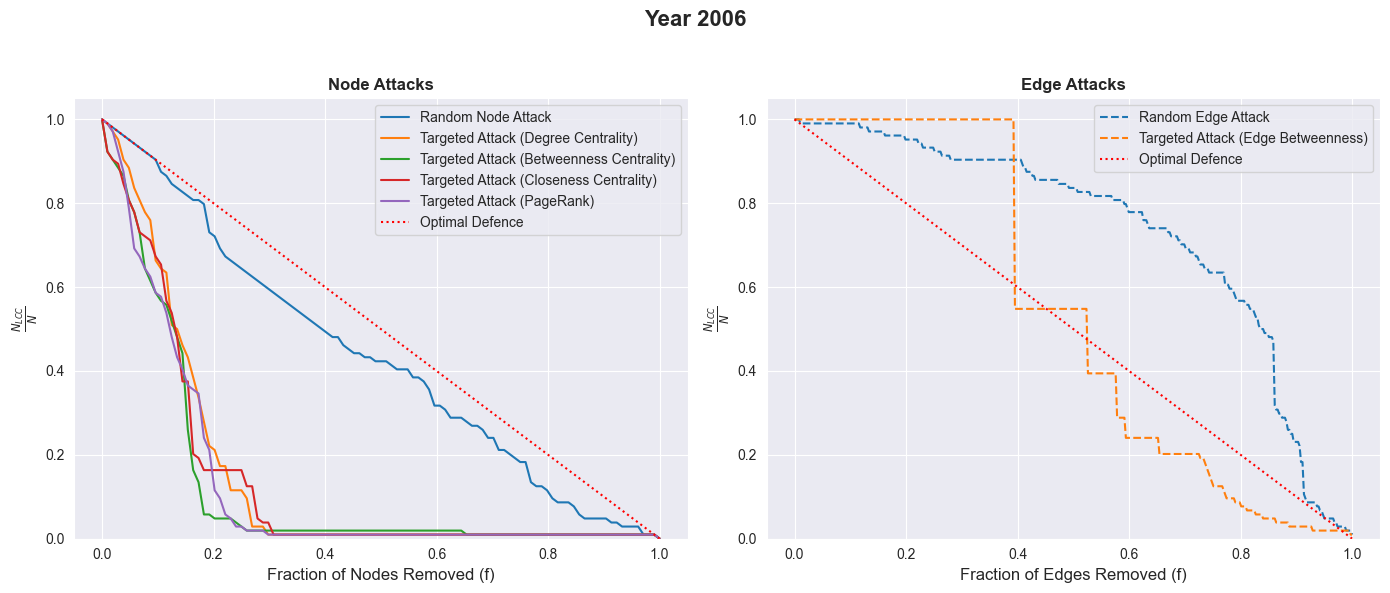

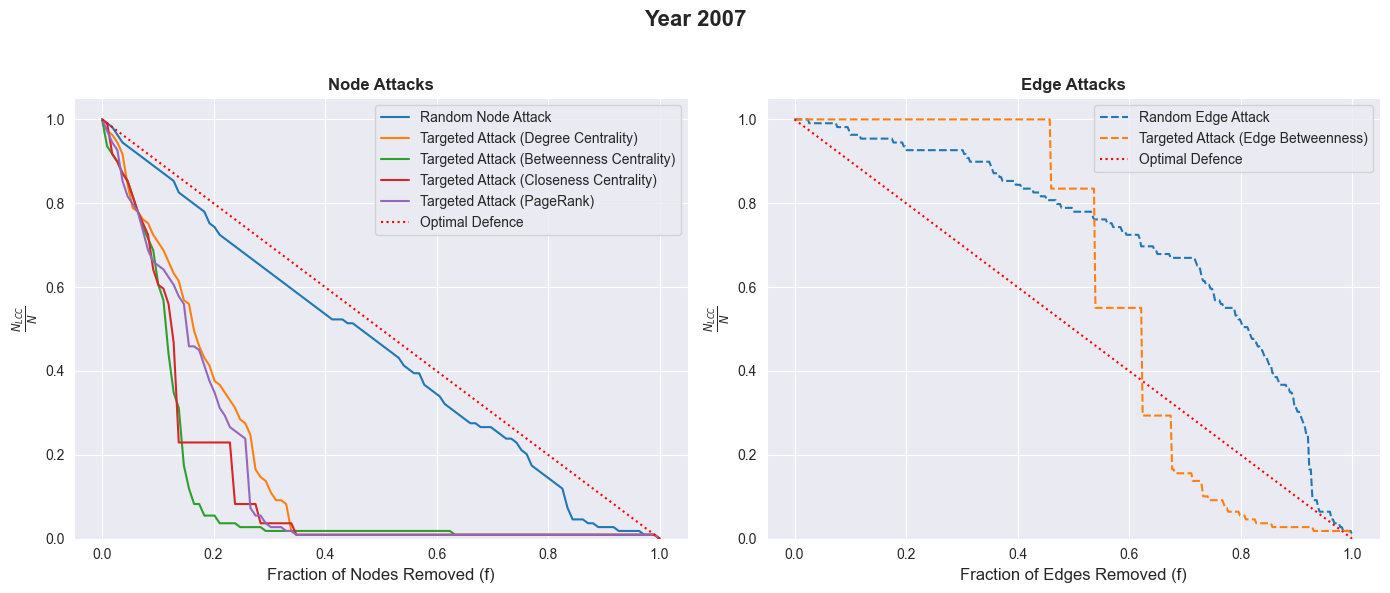

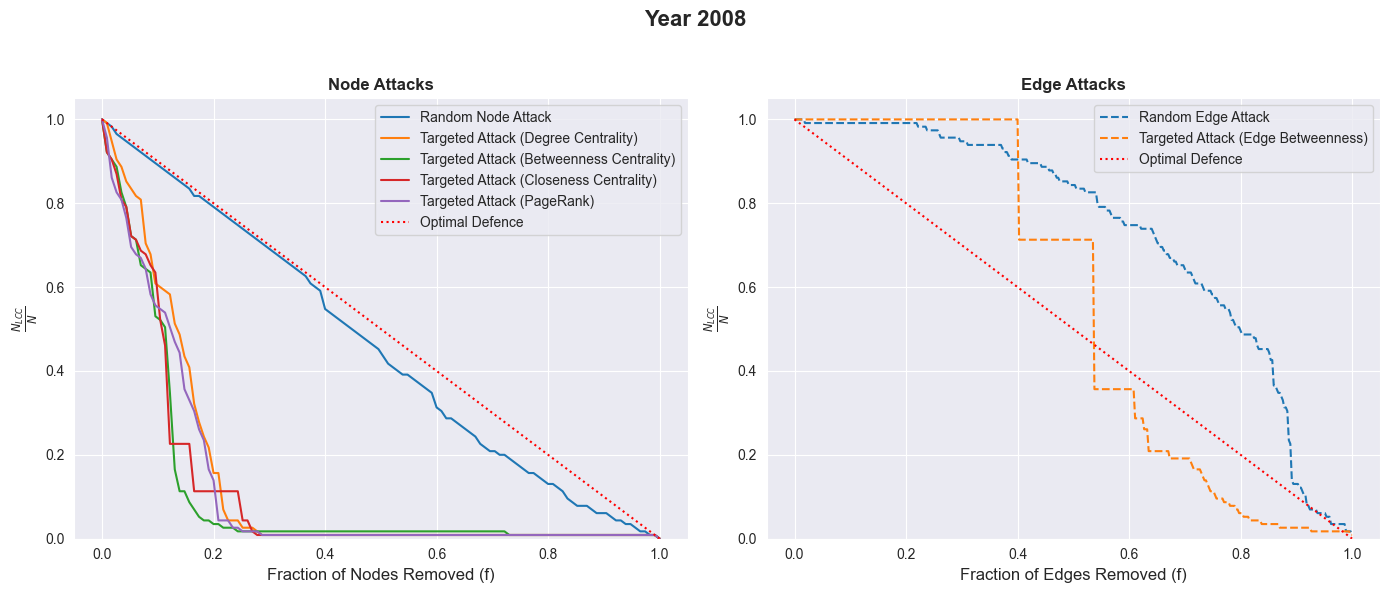

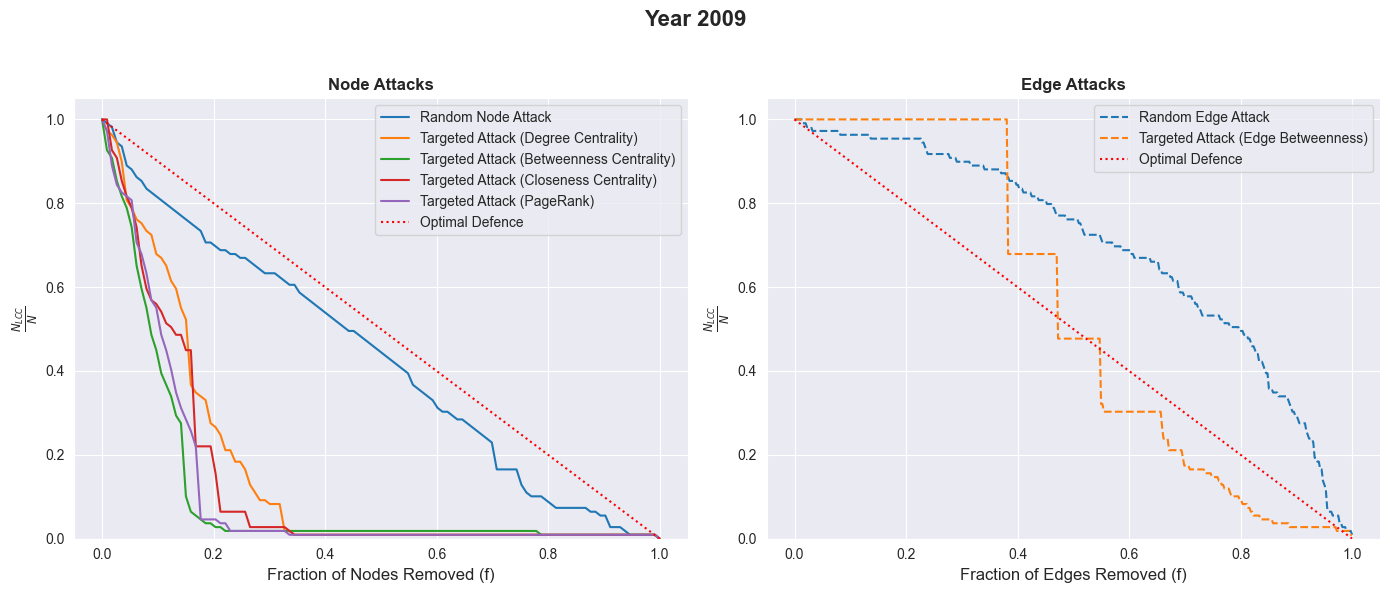

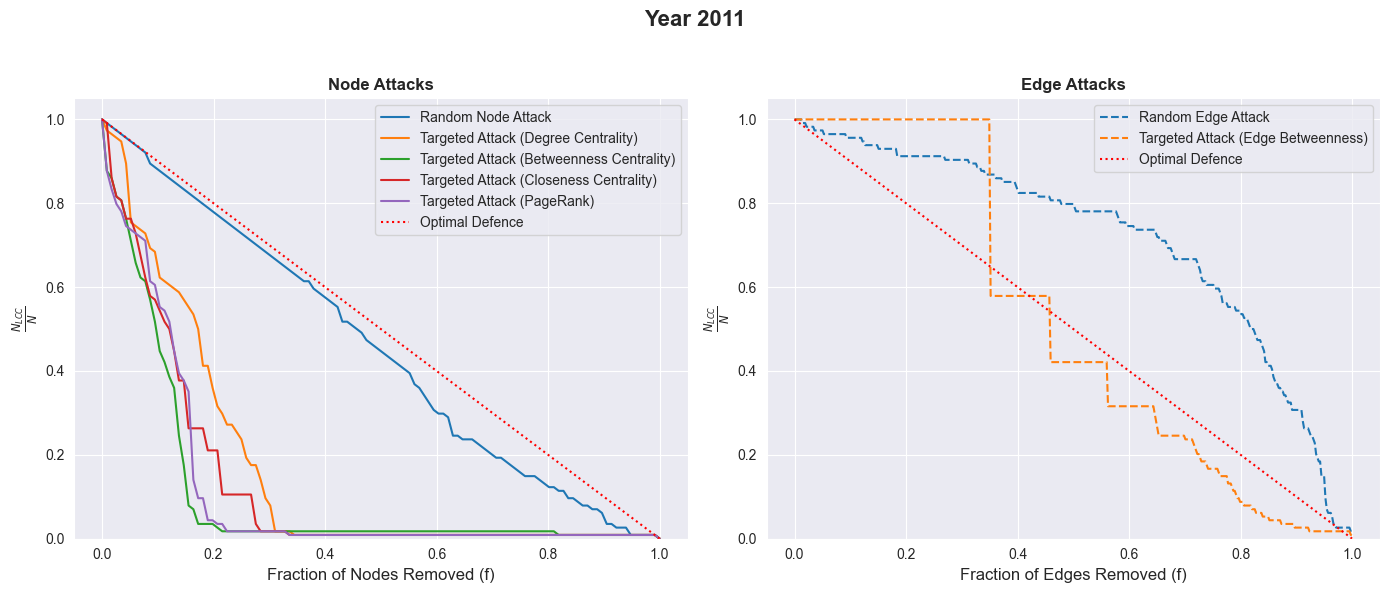

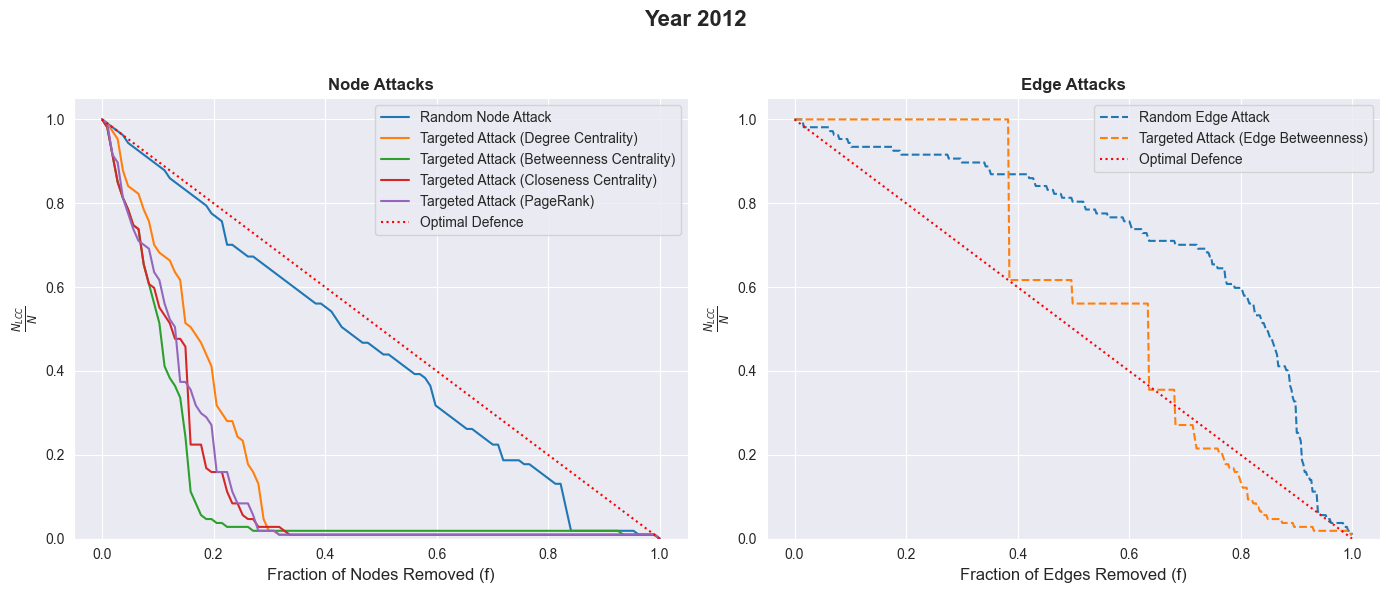

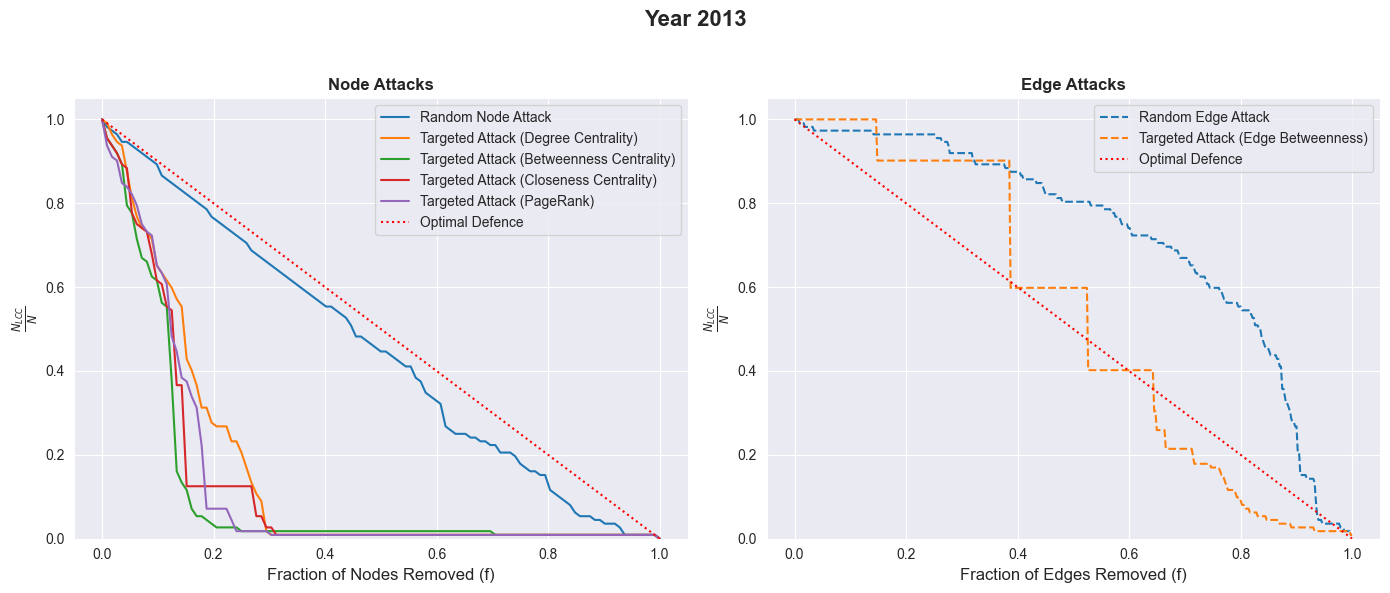

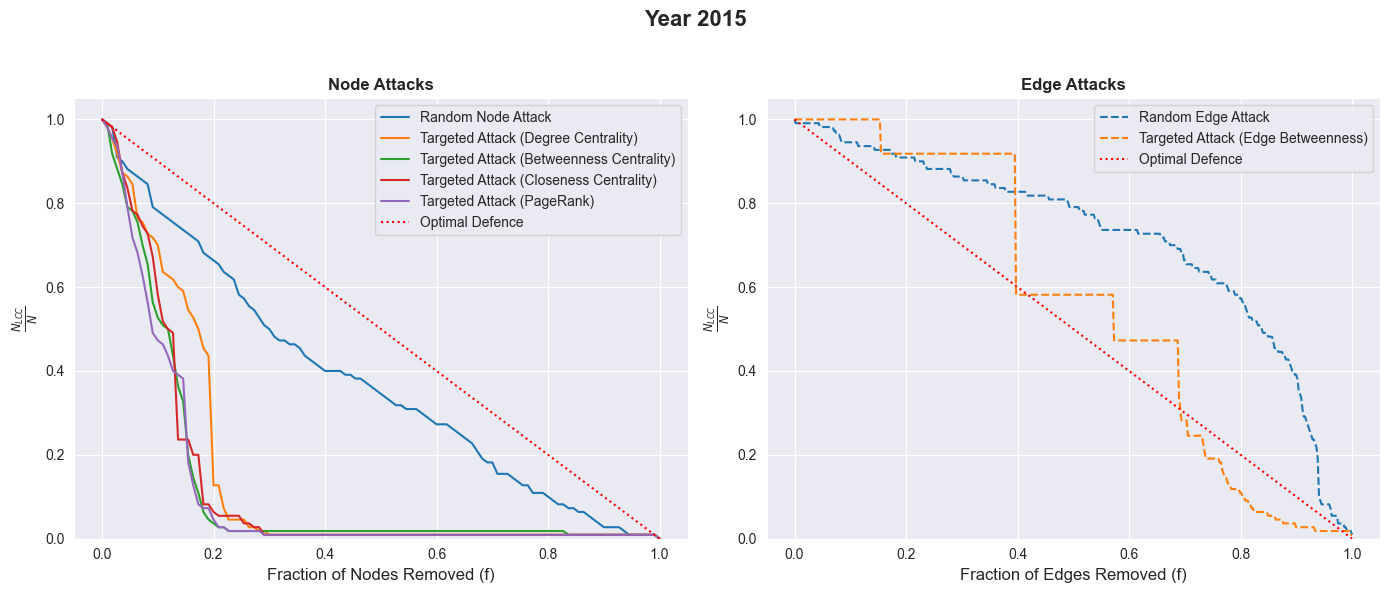

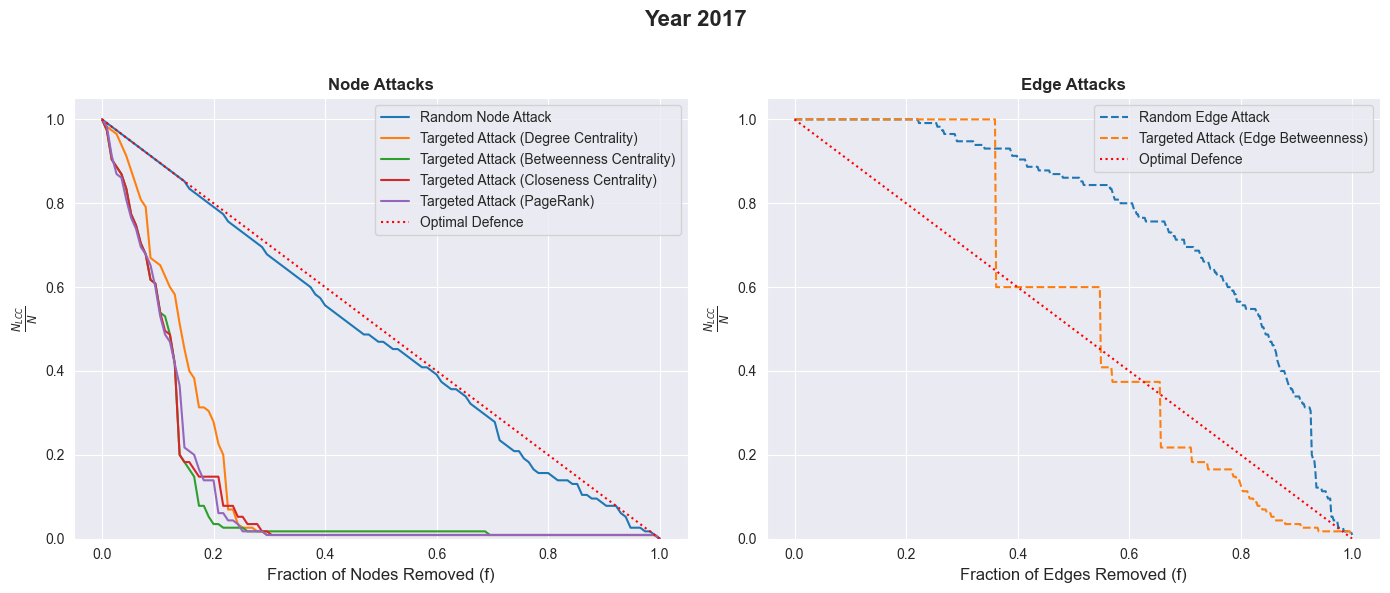

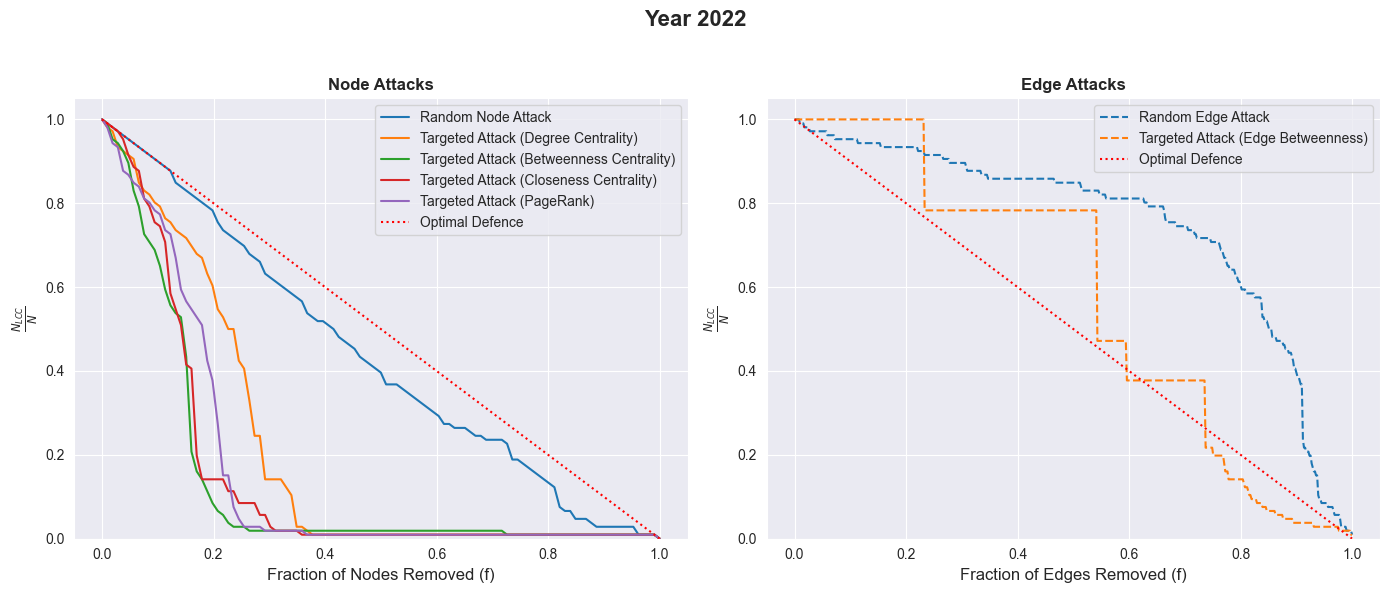

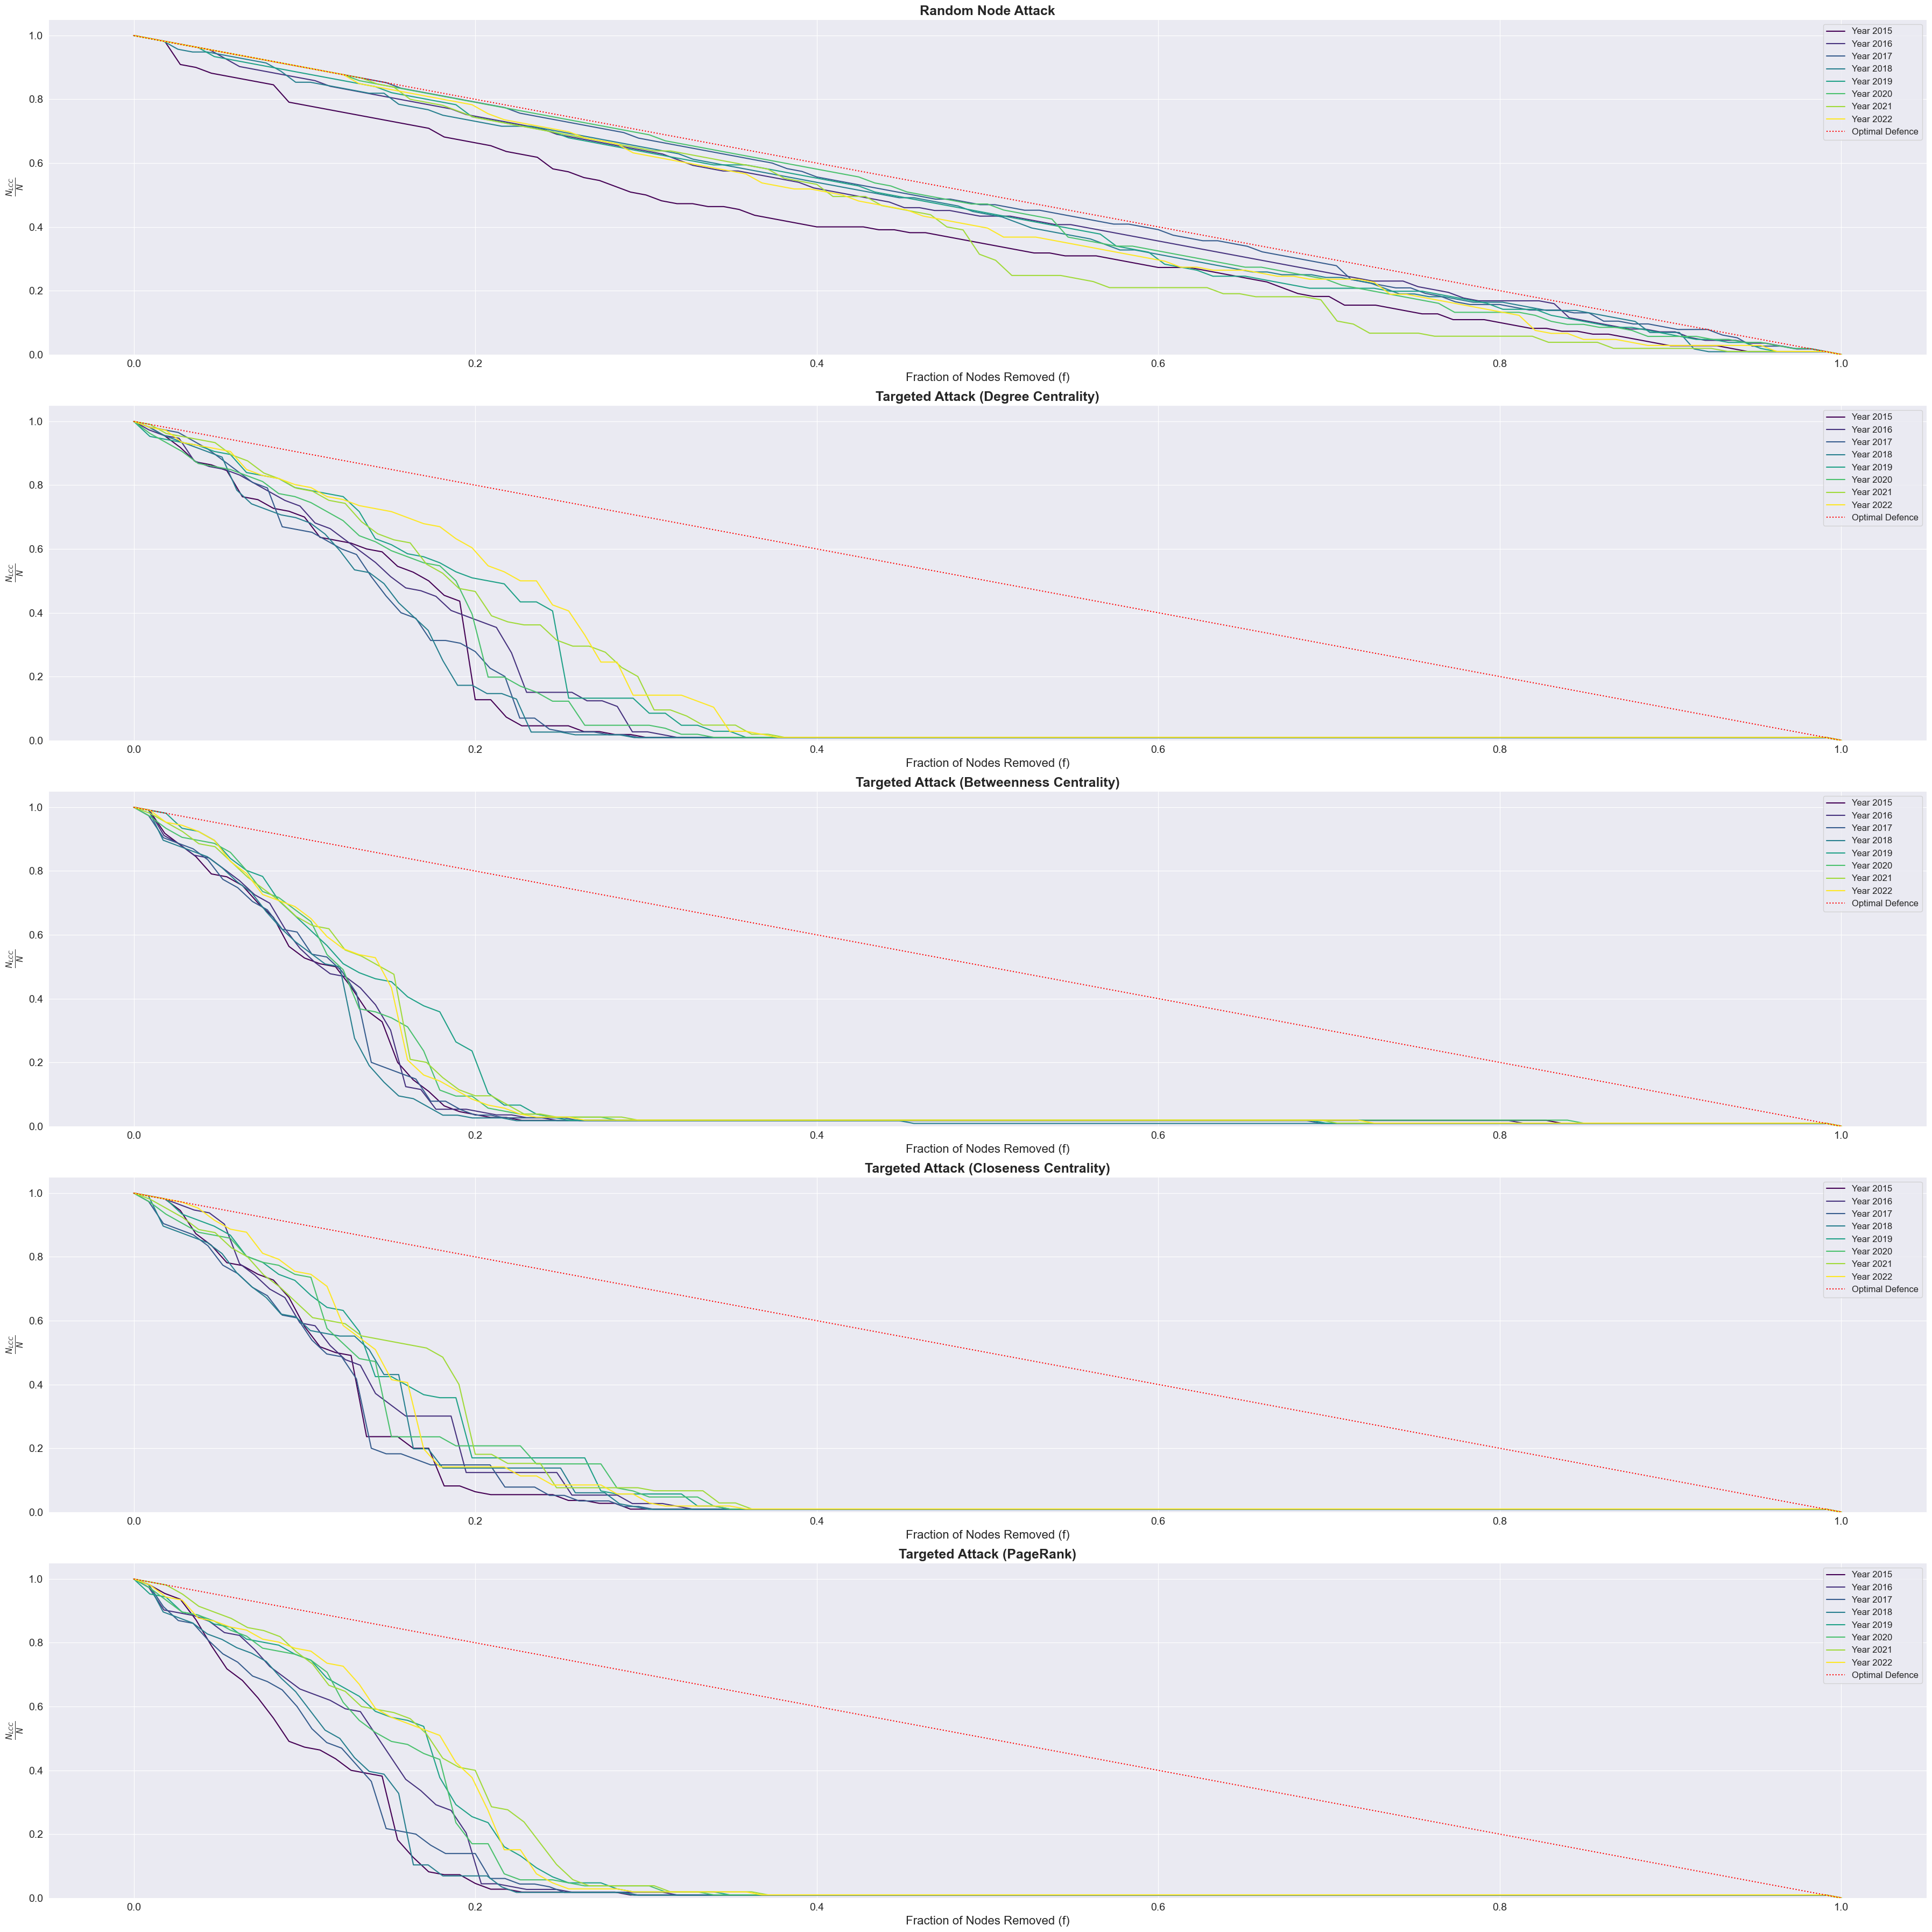

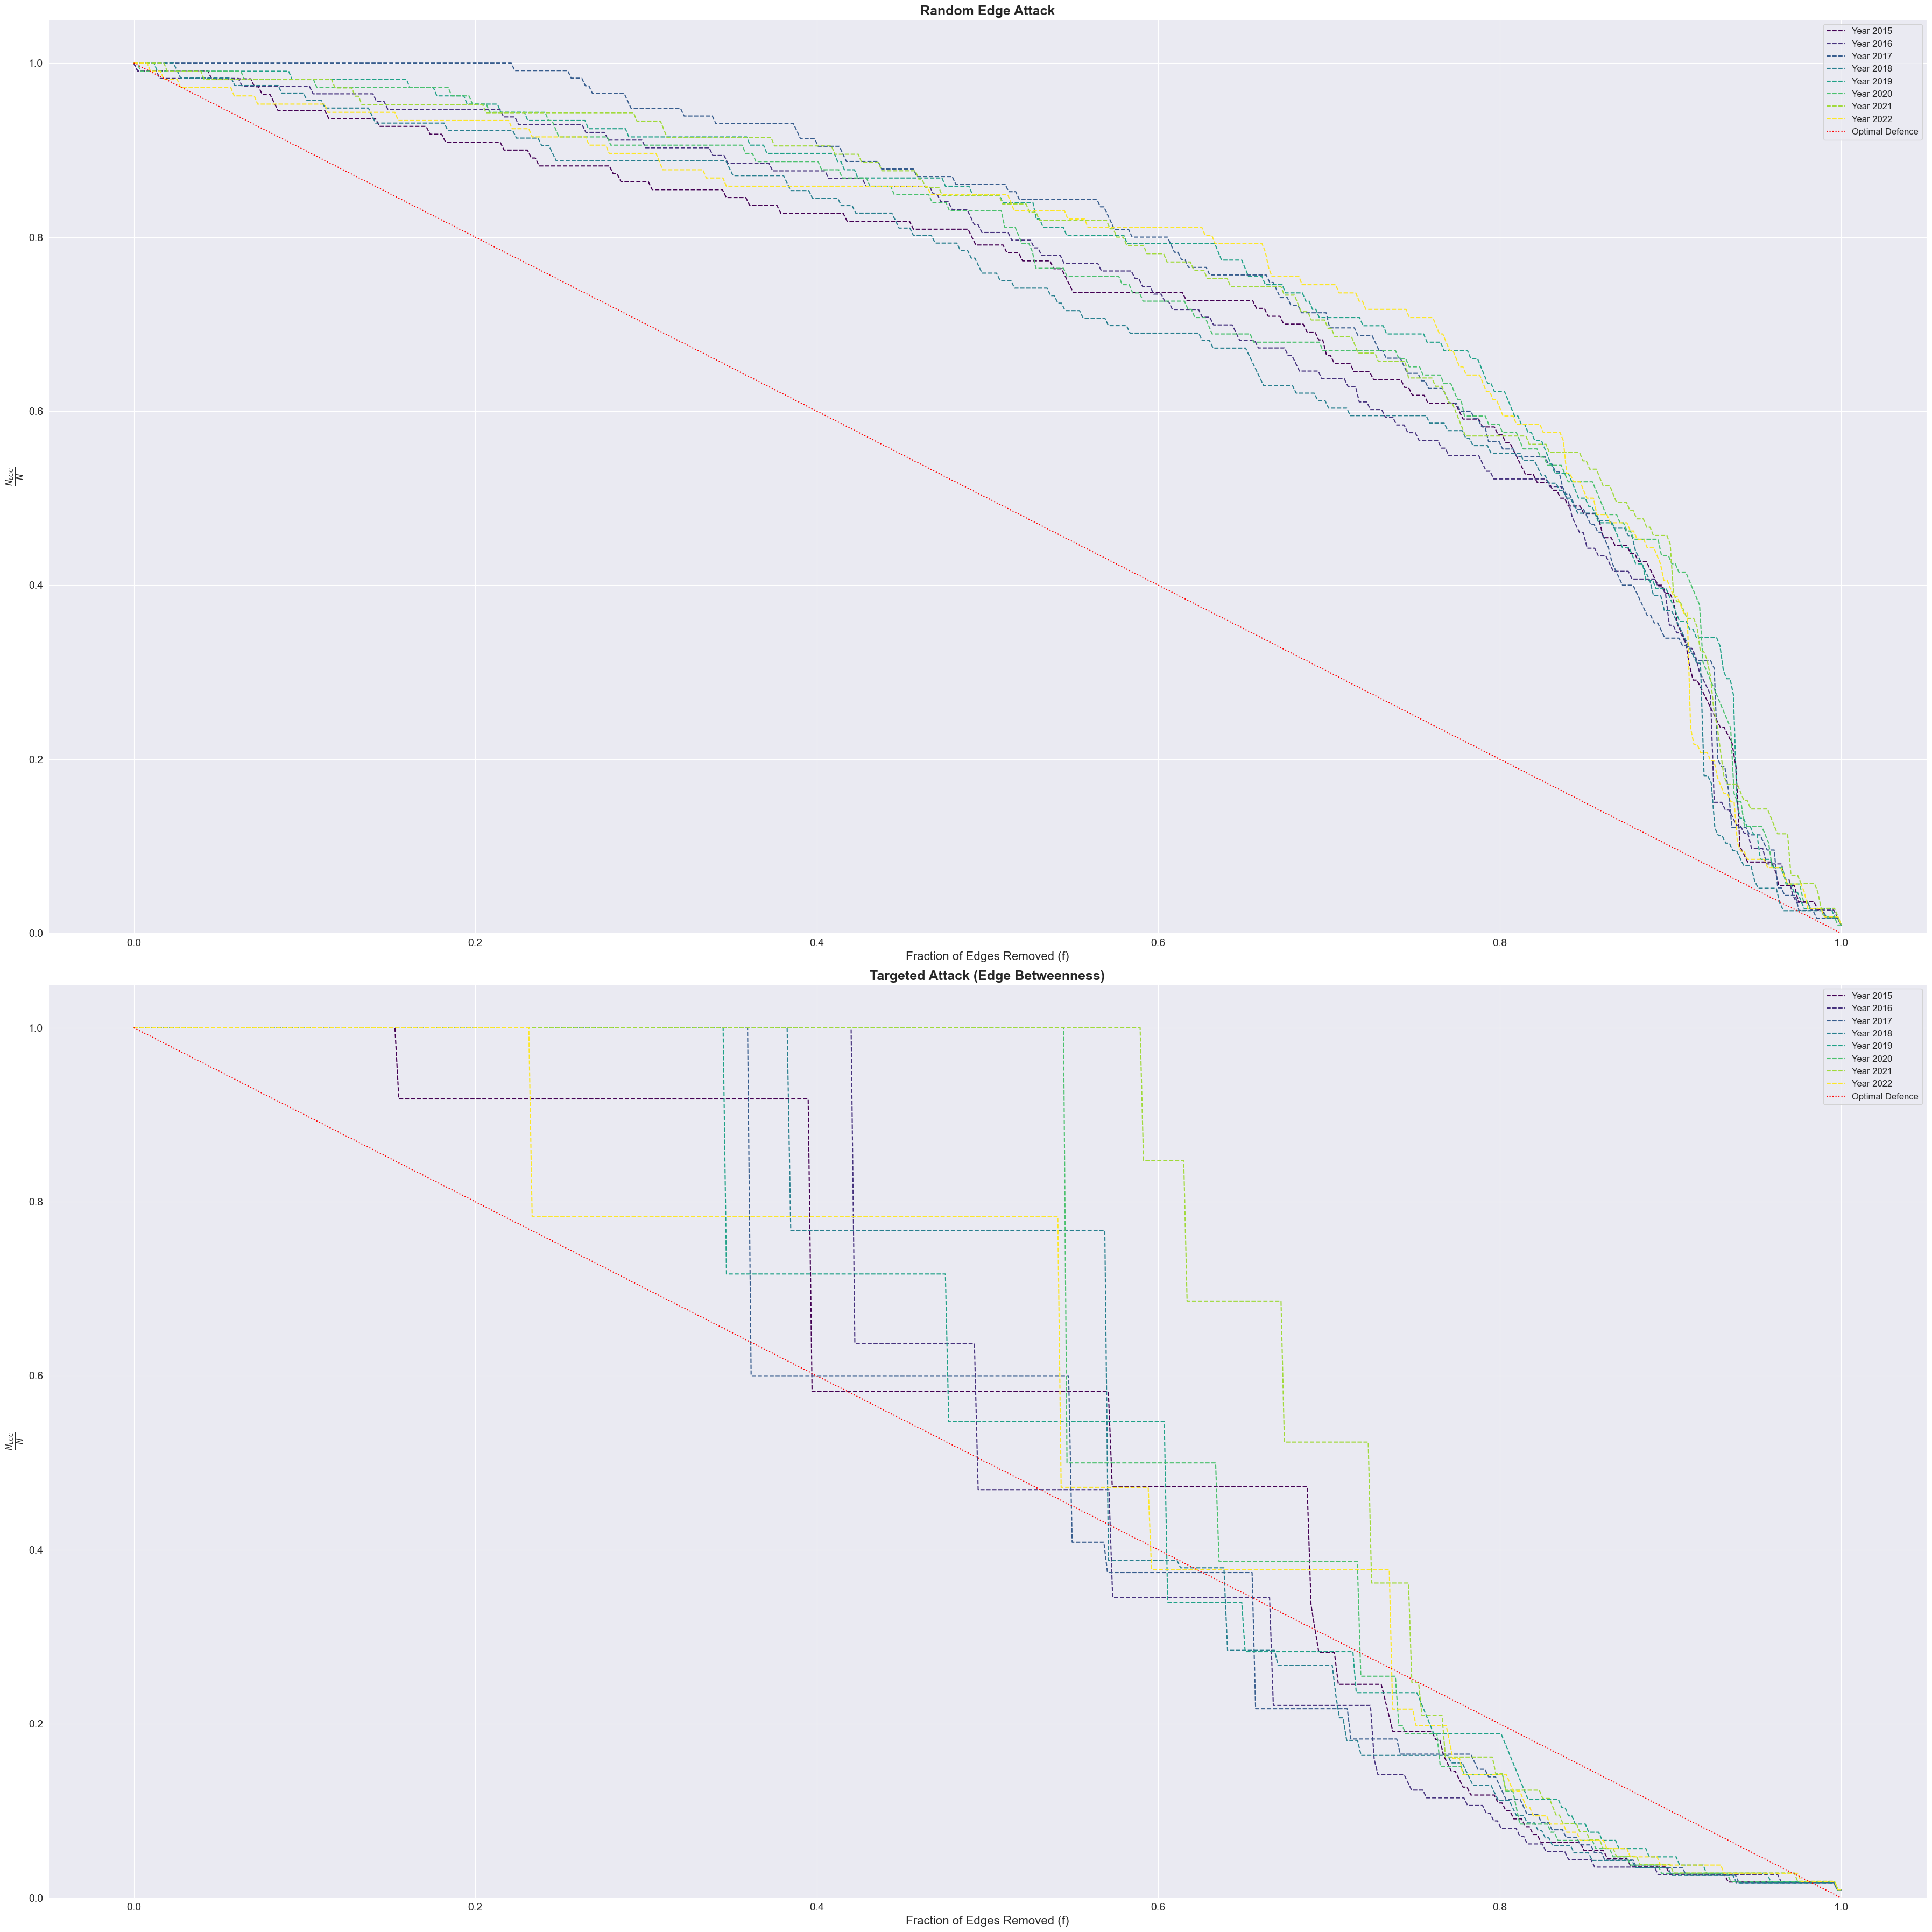

In [30]:
plt.rcParams['figure.figsize'] = (10, 6)
    
##############################################
# Attack Simulations
##############################################
def targeted_closeness_attack(G):
    """Remove highest closeness node iteratively."""
    G_copy = G.copy()
    lcc_sizes = [largest_cc_size(G_copy)]
    
    while len(G_copy) > 0:
        if len(G_copy) == 1:
            G_copy.remove_node(list(G_copy.nodes())[0])
            lcc_sizes.append(largest_cc_size(G_copy))
            break

        close = nx.closeness_centrality(G_copy, distance="inverse_weight")
        target = max(close, key=close.get)
        G_copy.remove_node(target)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

def targeted_eigenvector_attack(G):
    """Remove highest eigenvector centrality node iteratively."""
    G_copy = G.copy()
    lcc_sizes = [largest_cc_size(G_copy)]

    while len(G_copy) > 0:
        if len(G_copy) == 1:
            G_copy.remove_node(list(G_copy.nodes())[0])
            lcc_sizes.append(largest_cc_size(G_copy))
            break

        eig = nx.eigenvector_centrality(G_copy, max_iter=5000, weight='inverse_weight')
        target = max(eig, key=eig.get)
        G_copy.remove_node(target)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

def targeted_pagerank_attack(G):
    """Remove highest PageRank node iteratively."""
    G_copy = G.copy()
    lcc_sizes = [largest_cc_size(G_copy)]

    while len(G_copy) > 0:
        if len(G_copy) == 1:
            G_copy.remove_node(list(G_copy.nodes())[0])
            lcc_sizes.append(largest_cc_size(G_copy))
            break

        pr = nx.pagerank(G_copy, weight='inverse_weight')
        target = max(pr, key=pr.get)
        G_copy.remove_node(target)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

def targeted_edge_betweenness_attack(G):
    """Remove highest edge betweenness edge iteratively."""
    G_copy = G.copy()
    lcc_sizes = [largest_cc_size(G_copy)]
    
    while G_copy.number_of_edges() > 0:
        edge_bet = nx.edge_betweenness_centrality(G_copy, weight='inverse_weight')
        target = max(edge_bet, key=edge_bet.get)
        G_copy.remove_edge(*target)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

def largest_cc_size(G):
    if len(G) == 0:
        return 0
    return len(max(nx.connected_components(G), key=len))

def random_node_attack(G):
    """Remove nodes at random one by one, record LCC size."""
    nodes = list(G.nodes())
    random.shuffle(nodes)
    lcc_sizes = []
    G_copy = G.copy()
    initial_lcc = largest_cc_size(G_copy)
    lcc_sizes.append(initial_lcc)
    
    for n in nodes:
        G_copy.remove_node(n)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

def targeted_degree_attack(G):
    """Remove highest-degree node iteratively."""
    G_copy = G.copy()
    lcc_sizes = [largest_cc_size(G_copy)]
    
    while len(G_copy) > 0:
        deg = dict(G_copy.degree(weight='inverse_weight'))
        target = max(deg, key=deg.get)
        G_copy.remove_node(target)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

def targeted_betweenness_dynamic_attack(G):
    """Remove highest betweenness node each iteration (dynamic recalculation)."""
    G_copy = G.copy()
    lcc_sizes = [largest_cc_size(G_copy)]

    while len(G_copy) > 0:
        if len(G_copy) == 1:
            G_copy.remove_node(list(G_copy.nodes())[0])
            lcc_sizes.append(largest_cc_size(G_copy))
            break

        bet = nx.betweenness_centrality(G_copy, weight='inverse_weight')
        target = max(bet, key=bet.get)
        G_copy.remove_node(target)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

def random_edge_attack(G):
    """Remove edges at random one by one, record LCC size."""
    G_copy = G.copy()
    edges = list(G_copy.edges())
    random.shuffle(edges)
    lcc_sizes = [largest_cc_size(G_copy)]
    for e in edges:
        G_copy.remove_edge(*e)
        lcc_sizes.append(largest_cc_size(G_copy))
    return lcc_sizes

##############################################
# Prepare results_list for plot_attacks
##############################################
results_list = []
for y in years:
    G = yearly_graphs[y]
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    random_node_lcc = random_node_attack(G)
    targeted_deg_lcc = targeted_degree_attack(G)
    targeted_bet_lcc = targeted_betweenness_dynamic_attack(G)
    random_edge_lcc = random_edge_attack(G)

    targeted_close_lcc = targeted_closeness_attack(G)
    targeted_pr_lcc = targeted_pagerank_attack(G)
    targeted_edge_bet_lcc = targeted_edge_betweenness_attack(G)

    results = {
        'title': f"Year {y}",
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'random_node': random_node_lcc,
        'targeted_degree': targeted_deg_lcc,
        'targeted_betweenness_dynamic': targeted_bet_lcc,
        'random_edge': random_edge_lcc,
        'targeted_closeness': targeted_close_lcc,
        'targeted_pagerank': targeted_pr_lcc,
        'targeted_edge_betweenness': targeted_edge_bet_lcc
    }
    results_list.append(results)

##############################################
# Compute AUC (Robustness Index)
##############################################
def compute_auc(fractions, sizes):
    auc = 0.0
    for i in range(len(fractions)-1):
        x1, x2 = fractions[i], fractions[i+1]
        y1, y2 = sizes[i], sizes[i+1]
        auc += (x2 - x1) * (y1 + y2) / 2.0
    return auc

##############################################
# Visualization
##############################################
def plot_attacks(results_list):

    attack_types_node = [
        'random_node',
        'targeted_degree',
        'targeted_betweenness_dynamic',
        'targeted_closeness',
        'targeted_pagerank'
    ]
    
    attack_types_edge = [
        'random_edge',
        'targeted_edge_betweenness'
    ]

    attack_labels = {
        'random_node': 'Random Node Attack',
        'random_edge': 'Random Edge Attack',
        'targeted_degree': 'Targeted Attack (Degree Centrality)',
        'targeted_betweenness_dynamic': 'Targeted Attack (Betweenness Centrality)',
        'targeted_closeness': 'Targeted Attack (Closeness Centrality)',
        'targeted_eigenvector': 'Targeted Attack (Eigenvector Centrality)',
        'targeted_pagerank': 'Targeted Attack (PageRank)',
        'targeted_edge_betweenness': 'Targeted Attack (Edge Betweenness)'
    }

    graph_results = {}
    robustness_summary = []
    
    for results in results_list:
        title = results['title']
        num_nodes = results['num_nodes']
        num_edges = results['num_edges']

        graph_results[title] = {'num_nodes': num_nodes, 'num_edges': num_edges}

        for attack in attack_labels.keys():
            if attack in results:
                lcc_sizes = results[attack]
                initial_lcc_size = lcc_sizes[0]
                sizes = [size / initial_lcc_size for size in lcc_sizes]

                if attack in attack_types_node:
                    fractions_removed = [(i) / num_nodes for i in range(len(sizes))]
                elif attack in attack_types_edge:
                    fractions_removed = [(i) / num_edges for i in range(len(sizes))]
                else:
                    continue
                
                auc_value = compute_auc(fractions_removed, sizes)
                robustness_summary.append((title, attack_labels[attack], auc_value))
                
                graph_results[title][attack] = {
                    'fractions_removed': fractions_removed,
                    'sizes': sizes,
                    'auc': auc_value
                }

    ##############################################
    # Plot Individual Year Figures
    ##############################################
    for title, data in graph_results.items():
        fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
        fig.suptitle(title, fontsize=16, fontweight='bold')

        ax = axs[0]
        for attack in attack_types_node:
            if attack in data:
                fractions_removed = data[attack]['fractions_removed']
                sizes = data[attack]['sizes']
                ax.plot(fractions_removed, sizes, label=attack_labels[attack])

        ax.plot([0, 1], [1, 0], linestyle=':', label='Optimal Defence', color='red')
        ax.set_xlabel("Fraction of Nodes Removed (f)", fontsize=12)
        ax.set_ylabel(r"$\frac{N_{LCC}}{N}$", fontsize=12)
        ax.set_title("Node Attacks", fontweight="bold")
        ax.legend(fontsize='medium')
        ax.grid(True)
        ax.set_ylim(0, 1.05)

        ax = axs[1]
        for attack in attack_types_edge:
            if attack in data:
                fractions_removed = data[attack]['fractions_removed']
                sizes = data[attack]['sizes']
                ax.plot(fractions_removed, sizes, label=attack_labels[attack], linestyle='--')
        ax.plot([0, 1], [1, 0], linestyle=':', label='Optimal Defence', color='red')
        ax.set_xlabel("Fraction of Edges Removed (f)", fontsize=12)
        ax.set_ylabel(r"$\frac{N_{LCC}}{N}$", fontsize=12)
        ax.set_title("Edge Attacks", fontweight="bold")
        ax.legend(fontsize='medium')
        ax.grid(True)
        ax.set_ylim(0, 1.05)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    ##############################################
    # Prepare data for Aggregated Plots
    ##############################################
    attack_results_node = {attack: {} for attack in attack_types_node}
    attack_results_edge = {attack: {} for attack in attack_types_edge}

    for results in results_list:
        title = results['title']
        num_nodes = results['num_nodes']
        num_edges = results['num_edges']

        for attack in attack_labels.keys():
            if attack in results:
                lcc_sizes = results[attack]
                initial_lcc_size = lcc_sizes[0]
                sizes = [size / initial_lcc_size for size in lcc_sizes]

                if attack in attack_types_node:
                    fractions_removed = [(i) / num_nodes for i in range(len(sizes))]
                    attack_results_node[attack][title] = (fractions_removed, sizes)
                elif attack in attack_types_edge:
                    fractions_removed = [(i) / num_edges for i in range(len(sizes))]
                    attack_results_edge[attack][title] = (fractions_removed, sizes)

    cmap = plt.get_cmap("viridis")

    ##############################################
    # Aggregated Node Attacks
    ##############################################
    num_attacks_node = len(attack_types_node)
    cols = 1
    rows = (num_attacks_node + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(36, 36))
    axs = axs.flatten()
    
    for idx, attack in enumerate(attack_types_node):
        ax = axs[idx]
        titles = list(attack_results_node[attack].keys())

        titles = [t for t in titles if int(t.split()[-1]) >= 2015]
    
        N = len(titles)
        for i, t in enumerate(titles):
            fractions_removed, sizes = attack_results_node[attack][t]
            color = cmap(i / max(1, N-1))
            ax.plot(fractions_removed, sizes, label=t, color=color)
    
        ax.plot([0, 1], [1, 0], linestyle=':', label='Optimal Defence', color='red')
        ax.set_xlabel("Fraction of Nodes Removed (f)", fontsize=16)
        ax.set_ylabel(r"$\frac{N_{LCC}}{N}$", fontsize=16)
        ax.set_title(attack_labels[attack], fontweight="bold", fontsize=18)
        ax.grid(True)
        ax.legend(fontsize='large', loc='upper right')
        ax.set_ylim(0, 1.05)
        ax.tick_params(axis='both', which='major', labelsize=14)
    
    for k in range(num_attacks_node, rows*cols):
        fig.delaxes(axs[k])
    
    plt.tight_layout()
    plt.show()
    
    ##############################################
    # Aggregated Edge Attacks
    ##############################################
    num_attacks_edge = len(attack_types_edge)
    cols = 1
    rows = (num_attacks_edge + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(36, 36))
    if num_attacks_edge == 1:
        axs = [axs]
    
    for idx, attack in enumerate(attack_types_edge):
        ax = axs[idx]
        titles = list(attack_results_edge[attack].keys())

        titles = [t for t in titles if int(t.split()[-1]) >= 2015]
    
        N = len(titles)
        for i, t in enumerate(titles):
            fractions_removed, sizes = attack_results_edge[attack][t]
            color = cmap(i / max(1, N-1))
            ax.plot(fractions_removed, sizes, label=t, linestyle='--', color=color)
    
        ax.plot([0, 1], [1, 0], linestyle=':', label='Optimal Defence', color='red')
        ax.set_xlabel("Fraction of Edges Removed (f)", fontsize=16)
        ax.set_ylabel(r"$\frac{N_{LCC}}{N}$", fontsize=16)
        ax.set_title(attack_labels[attack], fontweight="bold", fontsize=18)
        ax.grid(True)
        ax.legend(fontsize='large', loc='upper right')
        ax.set_ylim(0, 1.05)
        ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    plt.show()
    
    robustness_df = pd.DataFrame(robustness_summary, columns=["Title", "Attack", "AUC"])
    return robustness_df
    
robustness_df = plot_attacks(results_list)

### Compare Centralities of 2020

In [31]:
def compare_centralities(G):
    graph_name = "Lithium Trade Network"

    degrees = dict(G.degree())
    mean_degree = np.mean(list(degrees.values()))
    mean_degree_squared = np.mean(np.square(list(degrees.values())))
    heterogeneity = mean_degree_squared / (mean_degree ** 2)
    closeness_centralities = nx.closeness_centrality(G, distance="inverse_weight")
    betweenness_centralities = nx.betweenness_centrality(G, weight="inverse_weight")
    eigenvector_centralities = nx.eigenvector_centrality(G, max_iter=1000, weight="inverse_weight")

    centrality_measures = {
        "Degree": degrees,
        "Closeness": closeness_centralities,
        "Betweenness": betweenness_centralities,
        "Eigenvector": eigenvector_centralities
    }

    centrality_values = {k: list(v.values()) for k, v in centrality_measures.items()}

    centrality_names = list(centrality_measures.keys())
    N_ROWS = len(centrality_names)
    fig1, axes1 = plt.subplots(N_ROWS, 2, figsize=(15, 4 * N_ROWS))
    if N_ROWS == 1:
        axes1 = [axes1]

    print(f"\nCentrality Distributions and Summary Statistics for {graph_name}:\n")
    print(f"Heterogeneity parameter: {heterogeneity:.4f}\n")
    for i, centrality_name in enumerate(centrality_names):
        values = centrality_values[centrality_name]

        mean_val = np.mean(values)
        median_val = np.median(values)
        std_val = np.std(values)
        max_val = np.max(values)
        min_val = np.min(values)
        zero_count = values.count(0)
        zero_proportion = zero_count / len(values)
        print(f"{centrality_name} Centrality:")
        print(f"Mean: {mean_val:.4f}, Median: {median_val:.4f}, Std Dev: {std_val:.4f}, "
              f"Max: {max_val:.4f}, Min: {min_val:.4f}")
        print(f"Proportion of zeros: {zero_proportion:.2%}\n")

        ax_hist = axes1[i][0]
        epsilon = 1e-10
        adjusted_values = [v if v > 0 else epsilon for v in values]
        num_bins = int(2 * len(adjusted_values) ** (1/3))  # Rice Rule
        bins = np.logspace(np.log10(min(adjusted_values)), np.log10(max(adjusted_values)), num_bins)
        ax_hist.hist(adjusted_values, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
        ax_hist.set_xscale('log')
        ax_hist.set_xlabel(f"{centrality_name} Centrality (Log Scale)")
        ax_hist.set_ylabel("Frequency")
        ax_hist.set_title(f"{centrality_name} Centrality Histogram")
        ax_ccdf = axes1[i][1]
        positive_values = [v for v in values if v > 0]

        sorted_values = np.sort(positive_values)
        ccdf = 1.0 - np.arange(1, len(sorted_values) + 1) / len(sorted_values)

        ax_ccdf.plot(sorted_values, ccdf, marker='o', linestyle='none', markersize=5, alpha=0.7)
        ax_ccdf.set_xscale('log')
        ax_ccdf.set_yscale('log')
        ax_ccdf.set_xlabel(f"{centrality_name} Centrality (Log Scale)")
        ax_ccdf.set_ylabel("CCDF (Log Scale)")
        ax_ccdf.set_title(f"{centrality_name} Centrality CCDF")

    plt.tight_layout()
    plt.savefig(
        os.path.join("graphics", hs_label, f"{hs_label}_centrality_analysis.png"),
        dpi=300,
        transparent=True
    )
    plt.show()

In [32]:
compare_centralities(yearly_graphs[2020])

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 1000 iterations')